# Çoklu Doğrusal Regresyon

### Bir şirket, ürünlerinin müşteriler tarafından nasıl değerlendirildiğini anlamak istiyor. Bu nedenle, müşterilerine bir anket gönderdiler ve ürünlerin kalitesi, fiyatı, reklamı ve müşteri hizmetleri gibi faktörlerle ilgili sorular sordular. Ankete 1000 kişi yanıt verdi.


#### Müşteri memnuniyeti: Bağımlı değişken. 1-10 arası bir değer alır.
#### Ürün Kalitesi: Bağımsız değişken, 1-10 arası bir değer alır.
#### Ürün fiyatı: Bağımsız değişken, 1-10 arası bir değer alır.
#### Reklam harcamaları: Bağımsız değişken, 1-10 arası bir değer alır.
#### Müşteri hizmetleri: Bağımsız değişken, 1-10 arası bir değer alır.

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

In [3]:
# veri setini oluşturalım.

np.random.seed(42)
data = pd.DataFrame({
    'urun_kalitesi':np.random.randint(1, 11, size=1000),
    'urun_fiyati': np.random.randint(1, 11, size=1000),
    'reklam_harcamalari': np.random.randint(1, 11, size=1000),
    'musteri_hizmetleri': np.random.randint(1, 11, size=1000)
})

# bağımlı değişkeni bağımsız değişkenler üzerinden hesaplayalım.

data['musteri_memnuniyeti'] = (0.3 * data['urun_kalitesi'] +
                               0.2 * data['urun_fiyati'] +
                               0.3 * data['reklam_harcamalari'] +
                               0.2 * data['musteri_hizmetleri'] +
                               np.random.normal(scale=1, size=1000))

data.head()

,urun_kalitesi,urun_fiyati,reklam_harcamalari,musteri_hizmetleri,musteri_memnuniyeti
0,7,1,10,8,5.746376
1,4,8,6,9,6.513624
2,8,4,7,6,6.103564
3,5,4,9,5,7.396628
4,7,5,1,6,6.099034


# Veri Analizi - Ön İşleme

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
urun_kalitesi,1000.0,5.448000,2.912005,1.000000,3.000000,5.000000,8.000000,10.000000
urun_fiyati,1000.0,5.470000,2.920896,1.000000,3.000000,5.000000,8.000000,10.000000
reklam_harcamalari,1000.0,5.459000,2.811089,1.000000,3.000000,5.000000,8.000000,10.000000
musteri_hizmetleri,1000.0,5.412000,2.873763,1.000000,3.000000,5.000000,8.000000,10.000000
musteri_memnuniyeti,1000.0,5.454358,1.761582,-0.173882,4.312557,5.426015,6.690385,10.921906


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   urun_kalitesi        1000 non-null   int32  
 1   urun_fiyati          1000 non-null   int32  
 2   reklam_harcamalari   1000 non-null   int32  
 3   musteri_hizmetleri   1000 non-null   int32  
 4   musteri_memnuniyeti  1000 non-null   float64
dtypes: float64(1), int32(4)
memory usage: 23.6 KB


In [7]:
# eksik gözlem analizi
data.isnull().sum()

urun_kalitesi          0
urun_fiyati            0
reklam_harcamalari     0
musteri_hizmetleri     0
musteri_memnuniyeti    0
dtype: int64

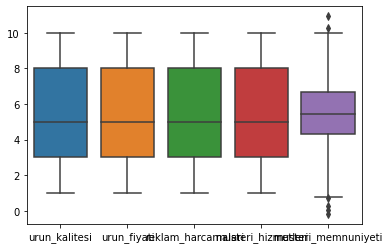

In [9]:
# aykırı gözlem analizi
sns.boxplot(data=data[['urun_kalitesi', 'urun_fiyati', 'reklam_harcamalari', 'musteri_hizmetleri', 'musteri_memnuniyeti']]);

#### görüldüğü üzere musteri_memnuniyeti isimli değişkende aykırı gözlem var. Hemen müdahale edelim.

In [27]:
df_table = data['musteri_memnuniyeti']

Q1 = df_table.quantile(0.25)
Q3 = df_table.quantile(0.75)
IQR = Q3 - Q1

alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

low = df_table[df_table < alt_sinir]
data['musteri_memnuniyeti'][low.index] = alt_sinir

high = df_table[df_table > ust_sinir]
data['musteri_memnuniyeti'][high.index] = ust_sinir

C:\Users\murat\AppData\Local\Temp\ipykernel_10432\3812934011.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['musteri_memnuniyeti'][low.index] = alt_sinir
C:\Users\murat\AppData\Local\Temp\ipykernel_10432\3812934011.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['musteri_memnuniyeti'][high.index] = ust_sinir


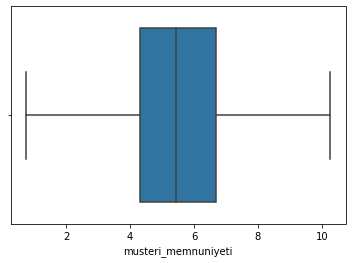

In [29]:
sns.boxplot(data=data, x='musteri_memnuniyeti');

# İstatiksel Analiz

#### Şimdi ise, değişkenler arasındaki ilişkinin istatistiksel olarak anlamlı olup olmadığını kontrol edelim.

In [31]:
# bağımlı ve bağımsız değişkenlerimi oluşturalım.

X = data[['urun_kalitesi', 'urun_fiyati', 'reklam_harcamalari', 'musteri_hizmetleri']]
y = data['musteri_memnuniyeti']

In [32]:
# İstatistiksel analiz modelimizi oluşturalım ve eğitelim.

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     musteri_memnuniyeti   R-squared (uncentered):                   0.970
Model:                             OLS   Adj. R-squared (uncentered):              0.970
Method:                  Least Squares   F-statistic:                              8188.
Date:                 Fri, 24 Mar 2023   Prob (F-statistic):                        0.00
Time:                         18:19:17   Log-Likelihood:                         -1403.3
No. Observations:                 1000   AIC:                                      2815.
Df Residuals:                      996   BIC:                                      2834.
Df Model:                            4                                                  
Covariance Type:             nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
urun_kalitesi          0.2913      0.009     31.178      0.000       0.273       0.310
urun_fiyati            0.2143      0.009     22.874      0.000       0.196       0.233
reklam_harcamalari     0.3070      0.010     31.889      0.000       0.288       0.326
musteri_hizmetleri     0.1889      0.009     19.973      0.000       0.170       0.207
==============================================================================
Omnibus:                        1.844   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.398   Jarque-Bera (JB):                1.851
Skew:                          -0.066   Prob(JB):                        0.396
Kurtosis:                       2.835   Cond. No.                         4.02
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Bu özet, modelin performansını özetler. R-kare, bağımsız değişkenlerin ne kadarının bağımlı değişkenin varyansını açıkladığını gösteren bir ölçüdür ve bu örnekte 0.97 'dir. Ayrıca F istatistiği, modelin anlamlılığını ölçer ve p değeri 0.00 'dır. Bu, p_value değerinin istatistiksel üst sınır olan 0.05 'den küçük olduğu anlamına gelir ve bu modelin bağımsız değişkenleri açıklama konusunda anlamlı olduğunu gösterir.

# Model Oluşturma ve Değerlendirme

In [40]:
# eğitim ve test setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# model oluşturma ve eğitme
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [42]:
# tahmin
y_pred = model.predict(X_test)

In [44]:
# model performansını değerlendirme
print('Ortalama Kare Hata (MSE): %.2f' % mean_squared_error(y_test, y_pred))
print('Belirleme Katsayısı (R2): %.2f' % r2_score(y_test, y_pred))

Ortalama Kare Hata (MSE): 1.01
Belirleme Katsayısı (R2): 0.68


#### MSE değerinin çok iyi olduğunu ve R-kare değerinin model tuning işlemleri ile daha iyi olabileceğini görüyoruz.

# Model Tuning İşlemi

In [45]:
# random_state için en iyi değeri bulma.

random_states = [0, 10, 20, 30, 42, 50, 60, 80, 100]

for element in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=element)
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f'random_state={element} için R-kare değeri: {r2}')

random_state=0 için R-kare değeri: 0.7073480907576479
random_state=10 için R-kare değeri: 0.7226628646043468
random_state=20 için R-kare değeri: 0.6698920903595651
random_state=30 için R-kare değeri: 0.6515538016915294
random_state=42 için R-kare değeri: 0.6799930812108839
random_state=50 için R-kare değeri: 0.7465981775057091
random_state=60 için R-kare değeri: 0.6594764273406808
random_state=80 için R-kare değeri: 0.6618010800162568
random_state=100 için R-kare değeri: 0.6792443241327735


#### Görüldüğü üzere en iyi değeri random_state=50 değeri için aldık. Modelimizi güncelleyelim.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
model = LinearRegression(copy_X=True, fit_intercept=False).fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('R-kare değeri: ', r2)

R-kare değeri:  0.747008490905483


In [50]:
# hiperparametreler için en iyi değeri araştıralım.

params = {'fit_intercept':[True, False], 'copy_X':[True, False]}
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)
print('En iyi parametreler: ', grid_search.best_params_)

En iyi parametreler:  {'copy_X': True, 'fit_intercept': False}


#### Hiperparametreler için bulduğumuz en iyi değerleri yukarıda modeli oluşturduğumuz kısıma ekliyorum.

# Model Doğrulama

In [51]:
scores = cross_val_score(grid_search, X_train, y_train, cv=5)
print('Doğrulama Skorları: ', scores)
print('Ortalama Doğrulama Skorları: ', scores.mean())

Doğrulama Skorları:  [0.62528348 0.70595366 0.66222848 0.67386604 0.6089414 ]
Ortalama Doğrulama Skorları:  0.6552546136324203


# Tahmin

In [53]:
data.head()

,urun_kalitesi,urun_fiyati,reklam_harcamalari,musteri_hizmetleri,musteri_memnuniyeti
0,7,1,10,8,5.746376
1,4,8,6,9,6.513624
2,8,4,7,6,6.103564
3,5,4,9,5,7.396628
4,7,5,1,6,6.099034


In [59]:
urun_kalitesi = input('Lütfen Ürün Kalitesini Puanlayınız (1-10): ')
urun_fiyati = input('Lütfen Ürün Fiyatını Puanlayınız (1-10): ')
reklam_harcamalari = input('Lütfen Reklam Harcamalarını Puanlayınız (1-10): ')
musteri_hizmetleri = input('Lütfen Müşteri Hizmetleri servisimizi puanlayınız (1-10): ')

predict = model.predict([[int(urun_kalitesi), int(urun_fiyati), int(reklam_harcamalari), int(musteri_hizmetleri)]])
print('-------------------------------------------------------------')
print(f'Tahmini Müşteri Memnuniyeti Fiyatı: {float(predict)}')

Lütfen Ürün Kalitesini Puanlayınız (1-10):  10
Lütfen Ürün Fiyatını Puanlayınız (1-10):  10
Lütfen Reklam Harcamalarını Puanlayınız (1-10):  10
Lütfen Müşteri Hizmetleri servisimizi puanlayınız (1-10):  10


-------------------------------------------------------------
Tahmini Müşteri Memnuniyeti Fiyatı: 9.99866728954704


C:\Users\murat\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
